# Multi-Layer Perceptron

## Libraries

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay, auc, precision_recall_curve


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Data

In [3]:
data = pd.read_csv("../data/parsed_data_final.csv", index_col = [0]) 

In [4]:
data

,Gene ID,Transcript ID,Position,Nucleotide 1,Nucleotide 2,Nucleotide 3,N1 Length Avg,N1 Length Median,N1 Length Min,N1 Length Max,...,N3 Length Max,N3 SD Avg,N3 SD Median,N3 SD Min,N3 SD Max,N3 Mean Avg,N3 Mean Median,N3 Mean Min,N3 Mean Max,Label
0,ENSG00000004059,ENST00000000233,244,AAGAC,AGACC,GACCA,0.008264,0.00697,0.00199,0.0339,...,0.0329,4.386989,3.440,0.773,15.50,80.570270,80.50,73.1,88.3,0
1,ENSG00000004059,ENST00000000233,261,CAAAC,AAACT,AACTG,0.006609,0.00564,0.00199,0.0222,...,0.0262,3.016599,2.660,0.715,14.10,94.290698,94.10,88.6,103.0,0
2,ENSG00000004059,ENST00000000233,316,GAAAC,AAACA,AACAG,0.007570,0.00631,0.00232,0.0299,...,0.0266,2.087146,1.910,0.630,6.85,89.364324,89.20,84.4,96.2,0
3,ENSG00000004059,ENST00000000233,332,AGAAC,GAACA,AACAT,0.010620,0.00902,0.00232,0.0370,...,0.0214,2.236520,2.135,0.884,6.49,89.154000,89.90,81.4,95.7,0
4,ENSG00000004059,ENST00000000233,368,AGGAC,GGACA,GACAA,0.010701,0.00896,0.00199,0.0478,...,0.0485,4.260253,4.160,1.040,8.81,85.178788,85.40,77.6,90.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,ENSG00000167747,ENST00000641834,1348,GGGAC,GGACA,GACAT,0.009594,0.00817,0.00232,0.0432,...,0.0242,4.005616,3.640,1.030,12.50,82.004110,82.10,74.0,92.8,1
121834,ENSG00000167747,ENST00000641834,1429,CTGAC,TGACA,GACAC,0.008393,0.00618,0.00232,0.0262,...,0.0149,3.644638,3.440,1.580,6.50,80.497101,80.60,75.0,90.6,0
121835,ENSG00000167747,ENST00000641834,1531,TGGAC,GGACA,GACAC,0.008161,0.00697,0.00232,0.0315,...,0.0260,2.181562,1.925,1.040,7.19,84.190625,84.50,78.2,88.1,1
121836,ENSG00000167747,ENST00000641834,1537,CTGAC,TGACC,GACCA,0.008044,0.00660,0.00232,0.0483,...,0.0144,2.540877,2.330,1.190,6.50,82.289474,82.00,77.6,87.4,0


In [11]:
X = data.drop(columns=['Position','Transcript ID','Label', 'Position', 'Nucleotide 1', 'Nucleotide 2', 'Nucleotide 3'])
y = data['Label']
groups = data['Gene ID']

gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=21)

for train_idx, test_idx in gss.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

X_train = X_train.drop(columns=['Gene ID'])
X_test = X_test.drop(columns=['Gene ID'])

Oversampling.

In [12]:
smote = SMOTE(random_state=21)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled class distribution: {Counter(y_train_resampled)}")


Resampled class distribution: Counter({0: 79775, 1: 79775})


Normalise the features for training.

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [14]:
X_train_scaled = np.array(X_train_scaled)
y_train = np.array(y_train_resampled)
X_test_scaled = np.array(X_test_scaled)
y_test = np.array(y_test)

## Model

In [15]:
model = Sequential()

# Input layer with 128 units and ReLU activation
model.add(Dense(128, input_dim=X_train_resampled.shape[1], activation='relu'))
model.add(Dropout(0.3))

# Hidden layer 1 with 64 units
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Hidden layer 2 with 32 units
model.add(Dense(32, activation='relu'))

# Hidden layer 3 with 16 units
model.add(Dense(16, activation='relu'))

# Output layer (binary classification, so use sigmoid)
model.add(Dense(1, activation='sigmoid'))

/Users/arnoldlek/Desktop/DSA4262/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
input_shape = X_train_resampled.shape[1]
print(f"Input shape: {input_shape}")

Input shape: 36


### Compiling

In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall', 'auc'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True)


### Training

In [19]:
history = model.fit(X_train_scaled, y_train, 
    validation_data=(X_test_scaled, y_test), 
    epochs=50, 
    batch_size=32, 
    callbacks=[early_stopping])

Epoch 1/50
4986/4986 ━━━━━━━━━━━━━━━━━━━━ 3s 668us/step - accuracy: 0.7848 - auc: 0.8657 - loss: 0.4582 - precision: 0.7898 - recall: 0.7747 - val_accuracy: 0.8112 - val_auc: 0.8479 - val_loss: 0.4321 - val_precision: 0.1534 - val_recall: 0.7146
Epoch 2/50
4986/4986 ━━━━━━━━━━━━━━━━━━━━ 3s 664us/step - accuracy: 0.8004 - auc: 0.8814 - loss: 0.4333 - precision: 0.8067 - recall: 0.7891 - val_accuracy: 0.7943 - val_auc: 0.8528 - val_loss: 0.4570 - val_precision: 0.1462 - val_recall: 0.7450
Epoch 3/50
4986/4986 ━━━━━━━━━━━━━━━━━━━━ 3s 696us/step - accuracy: 0.8115 - auc: 0.8918 - loss: 0.4153 - precision: 0.8166 - recall: 0.8029 - val_accuracy: 0.8160 - val_auc: 0.8555 - val_loss: 0.4283 - val_precision: 0.1593 - val_recall: 0.7298
Epoch 4/50
4986/4986 ━━━━━━━━━━━━━━━━━━━━ 3s 649us/step - accuracy: 0.8175 - auc: 0.8993 - loss: 0.4012 - precision: 0.8235 - recall: 0.8068 - val_accuracy: 0.8169 - val_auc: 0.8586 - val_loss: 0.4226 - val_precision: 0.1602 - val_recall: 0.7310
Epoch 5/50
4986/

1197/1197 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
AUC Score: 0.8677


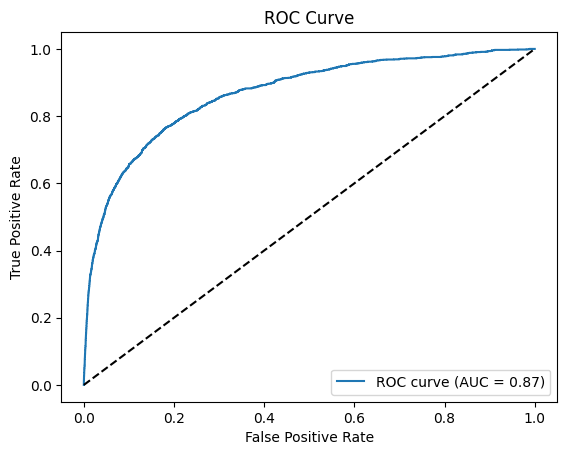

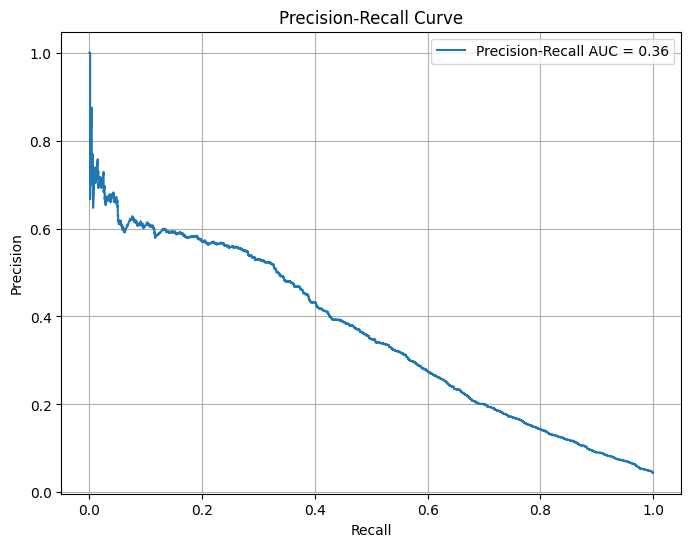

Text(0.5, 1.0, 'Confusion Matrix for QDA')

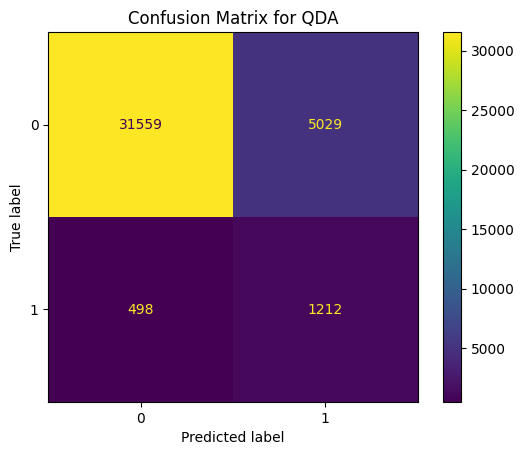

In [20]:
# Predict probabilities for the test set
y_pred_proba = model.predict(X_test_scaled)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

# Plot the ROC curve
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# PR-AUC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Compute the AUC for the precision-recall curve
pr_auc = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

# Confusion matrix
y_pred_class = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to class labels
cm = confusion_matrix(y_test, y_pred_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.title('Confusion Matrix for QDA')